# FlyMeeting Talk Figures

In [2]:
import os
import sys
from pathlib import Path
from itertools import zip_longest

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot
from larval_gonad.config import memory
from larval_gonad.cell_selection import SOMA, EARLY_GERM, LATE_GERM
from larval_gonad.x_to_a import multi_chrom_boxplot, commonly_expressed, CHROMS_CHR

# Setup notebook
nbconfig = Nb.setup_notebook(subproject_dir='../output/FlyMeeting_2018_talk', seurat_dir='../output/combined_testis_force', formats=['png', 'pdf'], styles=['notebook', 'talk'])

last updated: 2018-04-10 
Git hash: 6eb6ba5ecfa67f0cc16e9f71644f0e86b7762ef2


In [3]:
colors = sns.color_palette('tab20', n_colors=12, desat=.8)
greys = sns.color_palette('Greys')
reds = sns.color_palette('Reds')
reds[0] = greys[1]
blacks = [greys[1], '#000000']

boxplot_colors = [
    reds[-1],     # X
    '#ffffff', # 2L
    '#ffffff', # 2R
    '#ffffff', # 3L
    '#ffffff', # 3R
    reds[-1],     # 4
]

In [4]:
clusters = nbconfig.seurat.get_clusters()
tsne = nbconfig.seurat.get_tsne()
norm = nbconfig.seurat.get_normalized_read_counts()

## Cluster tSNE

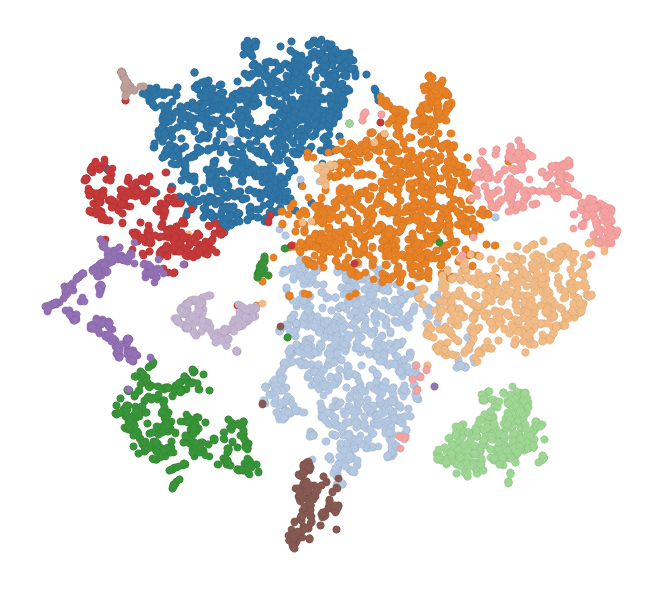

In [4]:
@make_figs(nbconfig.fig_name('tsne_clusters'), styles=nbconfig.styles, formats=nbconfig.formats)
def _plot():
    TSNEPlot(data=tsne.join(clusters['res.0.4']), hue='res.0.4', palette=colors, s=30)
    ax = plt.gca()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    sns.despine(left=True, bottom=True)
    ax.legend_.remove()
    
_plot()

## Example Gene tSNEs

In [5]:
def gene_tsne(gene, ax=None, cbar=False, **kwargs):
    fbgn = nbconfig.symbol2fbgn[gene]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    try:
        TSNEPlot(data=tsne.join(norm.T), hue=fbgn, palette=reds, ax=ax, cbar=cbar, s=30, **kwargs)
    except KeyError:
        pass

    ax.set_aspect('equal')
    ax.set_title(f'{gene}', fontdict={'style': 'italic'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tight_layout(rect=[0, 0, 1, .95])

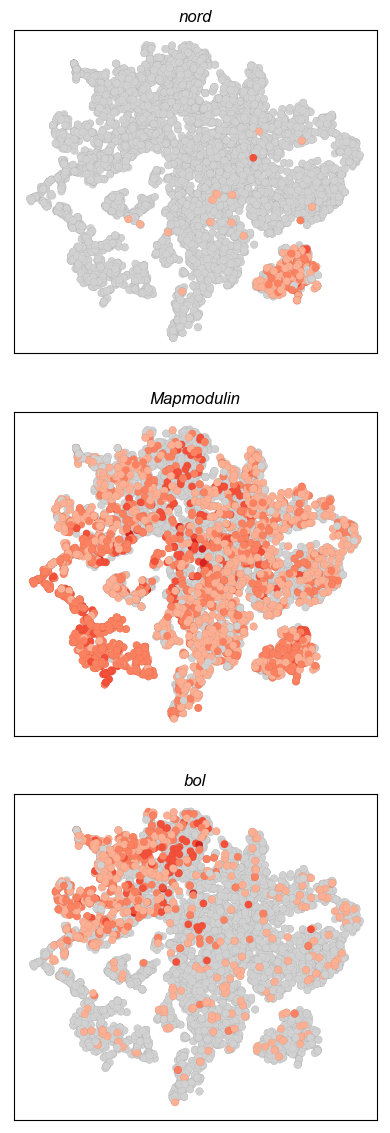

In [24]:
@make_figs(nbconfig.fig_name('tsne_example_genes'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    genes = ['nord', 'Mapmodulin', 'bol']
    fig, axes = plt.subplots(3, 1, figsize=plt.figaspect(3))
    for gene, ax in zip_longest(genes, axes):
        gene_tsne(gene, ax=ax)

plot_rep()

## X To A Analysis (commonly expressed)

In [26]:
expressed = commonly_expressed(norm)
dat = norm.T.join(clusters['res.0.4'])
dat.rename({'res.0.4': 'cluster'}, inplace=True, axis=1)

In [27]:
def strip_chr(ax):
    labels = ax.get_xticklabels()
    new = []
    for l in labels:
        new.append(l.get_text().strip('chr'))
        
    ax.set_xticklabels(new)

In [28]:
def plot_cluster_x2a(df, fbgns, cluster_id, name):
    idx = dat.query(f'cluster == {cluster_id}').index
    dat.drop('cluster', axis=1)
    data = dat.loc[idx, fbgns].median().to_frame().join(nbconfig.fbgn2chrom).query('chrom != "chrY"')
    data.columns = ['Normalized Expression', 'Chromosome']
    _tsne = tsne.copy()
    _tsne['on'] = 0
    _tsne.loc[idx, 'on'] = 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2), facecolor='w')
    
    TSNEPlot(data=_tsne, hue='on', cmap={0: greys[1], 1: colors[cluster_id]}, ax=ax1, s=60, linewidth=.1)
    
    multi_chrom_boxplot('Chromosome', 'Normalized Expression', data=data, flierprops={'alpha': .6}, notch=True, 
                        palette=boxplot_colors, use_text=False, multiplier=(1.2, .5), ax=ax2, zorder=2)
    
    ax1.legend_.remove()
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    
    ax2.set_ylim(None, 6.5);
    ax2.set_xlabel('')
    strip_chr(ax2)
    
    plt.suptitle(name)

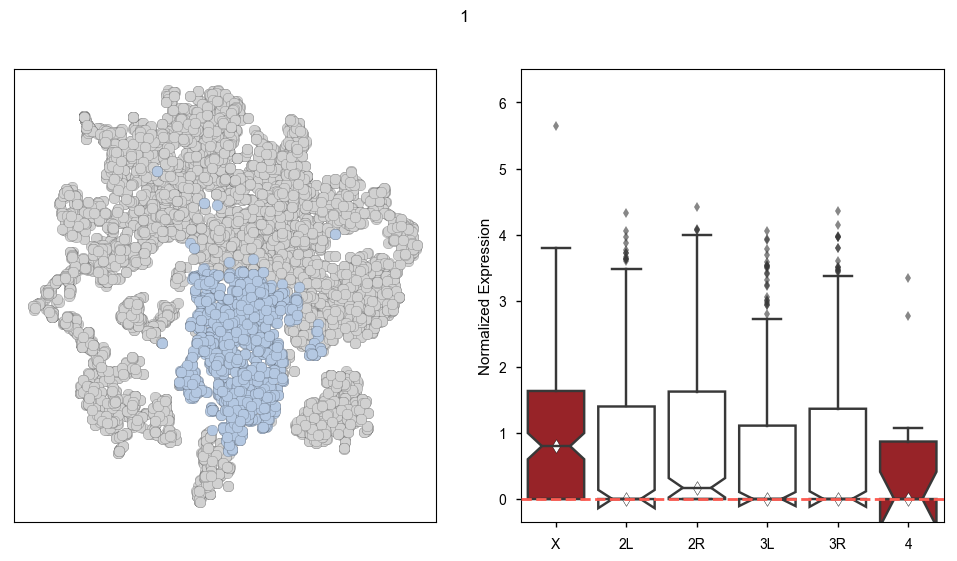

In [50]:
plot_cluster_x2a(dat, expressed, 1, '1')

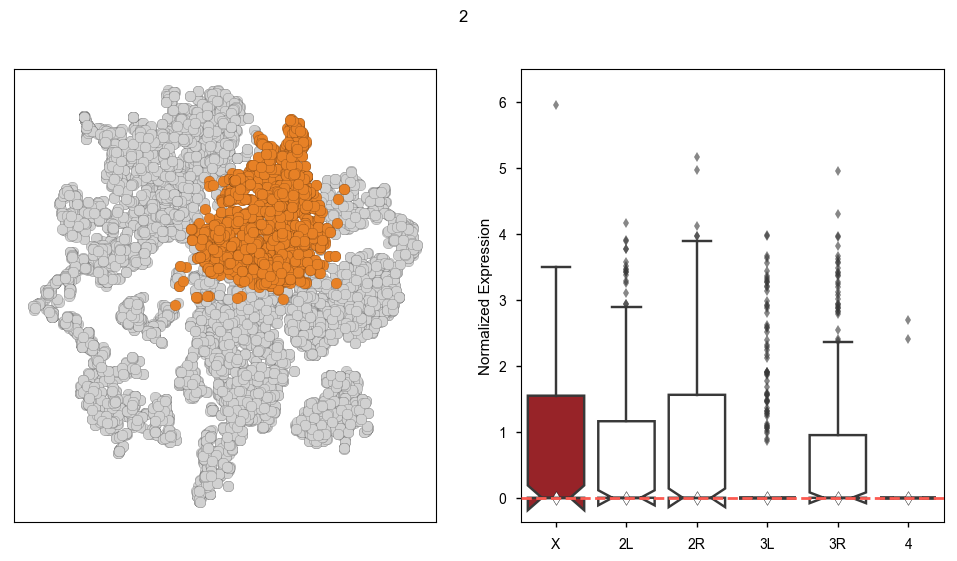

In [51]:
plot_cluster_x2a(dat, expressed, 2, '2')

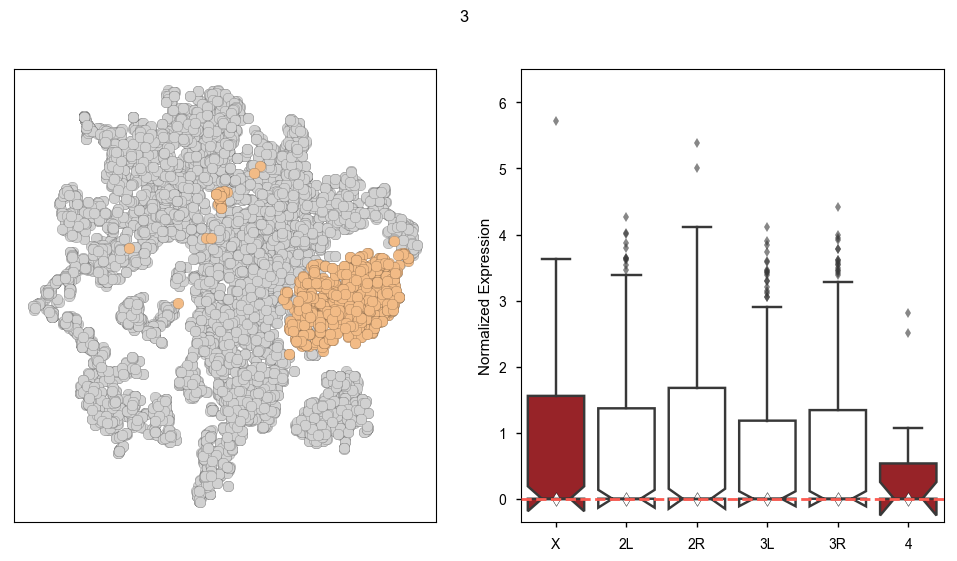

In [52]:
plot_cluster_x2a(dat, expressed, 3, '3')

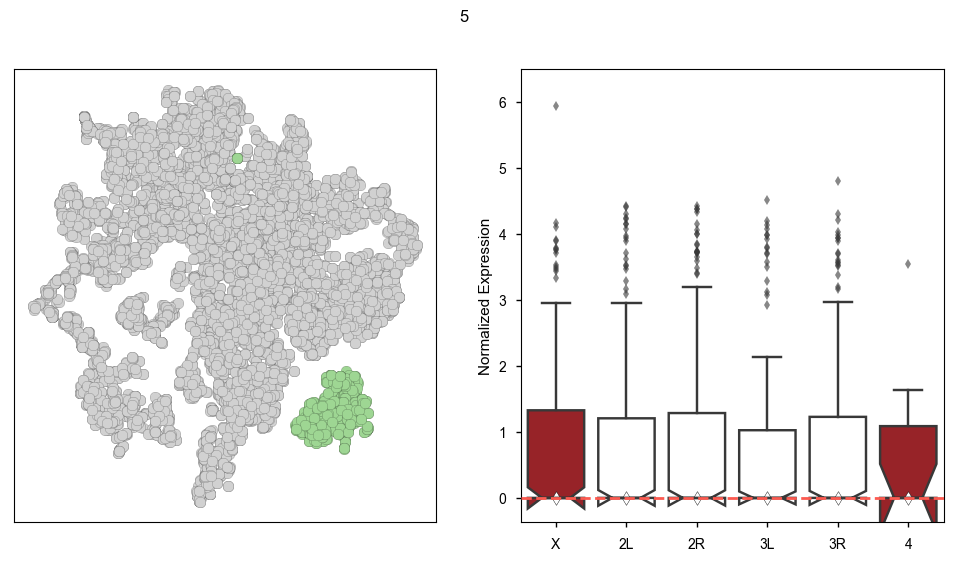

In [53]:
plot_cluster_x2a(dat, expressed, 5, '5')

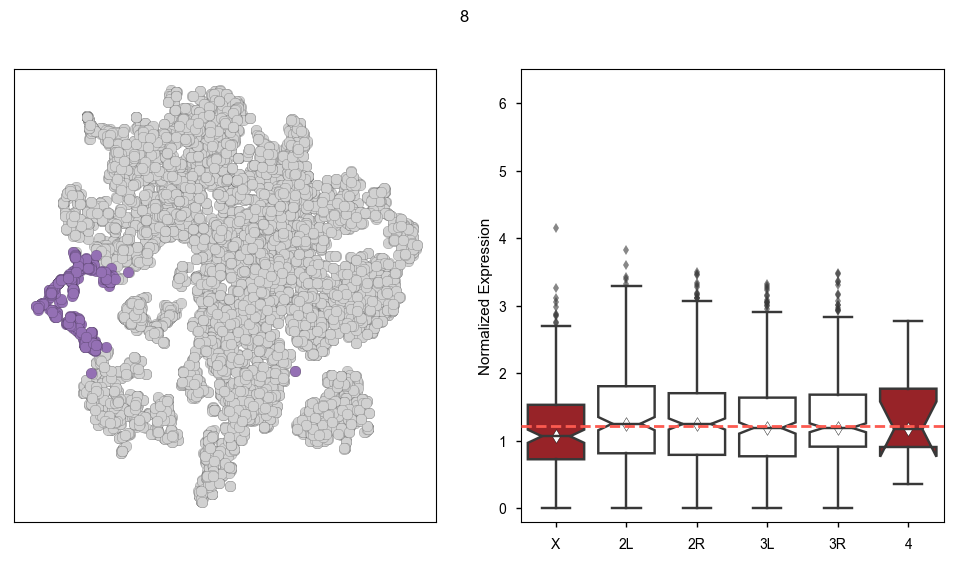

In [54]:
plot_cluster_x2a(dat, expressed, 8, '8')

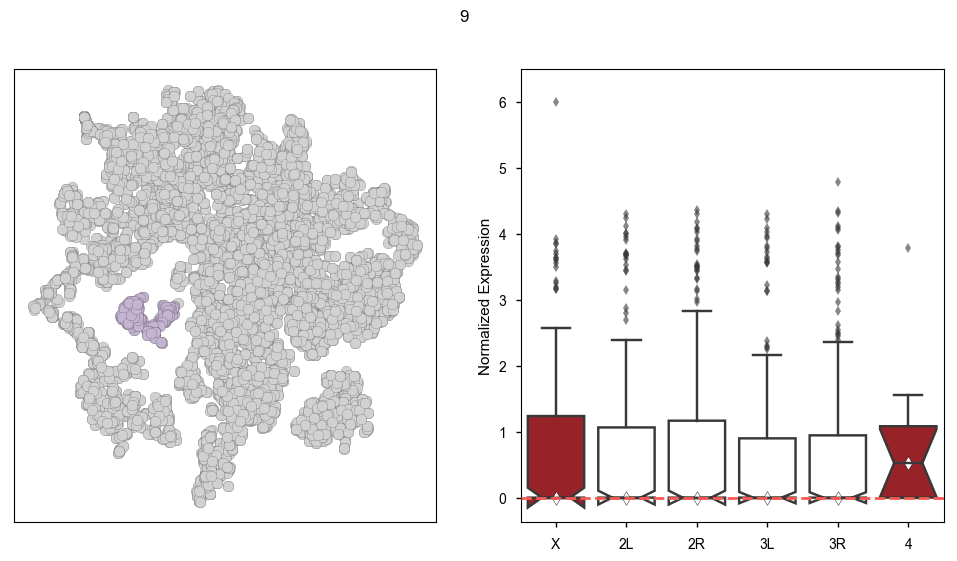

In [55]:
plot_cluster_x2a(dat, expressed, 9, '9')

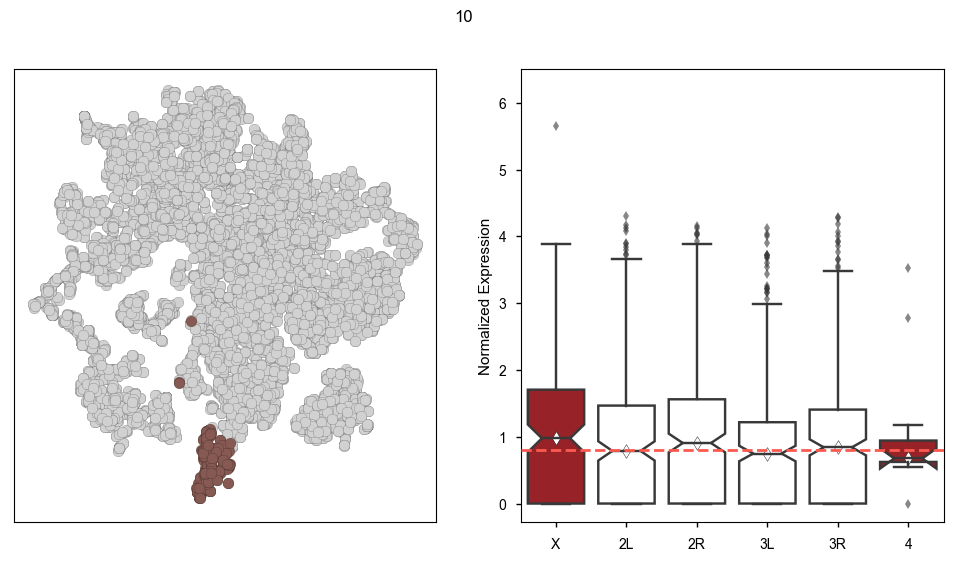

In [57]:
plot_cluster_x2a(dat, expressed, 10, '10')

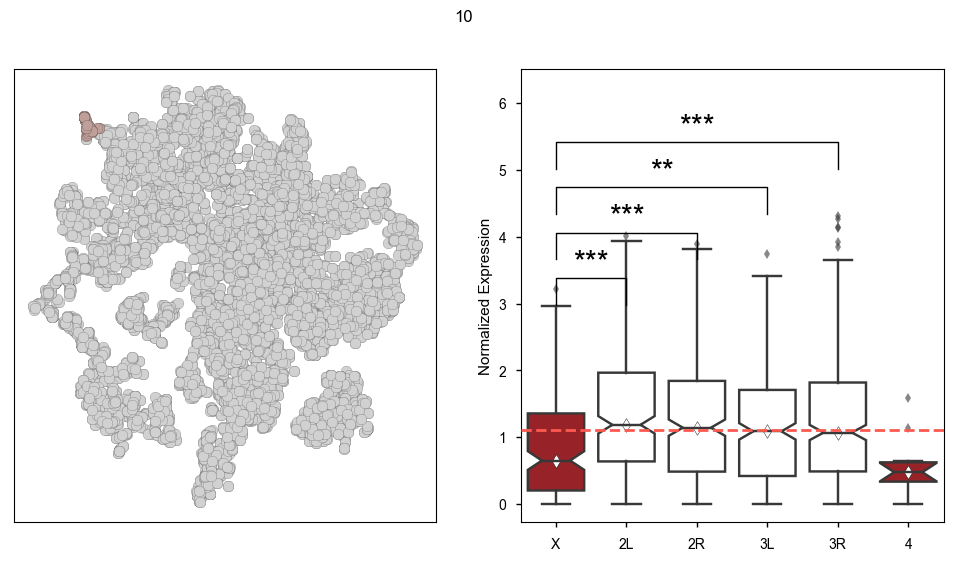

In [59]:
plot_cluster_x2a(dat, expressed, 11, '10')

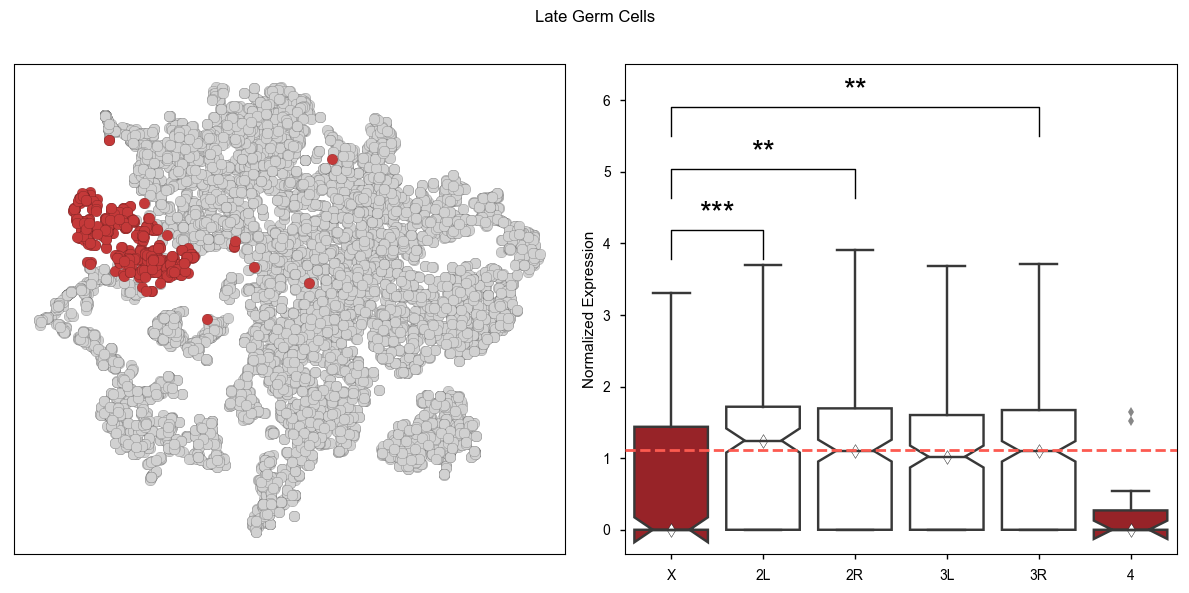

In [60]:
@make_figs(nbconfig.fig_name('tsne_boxplot_late_germcells'), styles=nbconfig.styles, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .92]})
def _plot():
    plot_cluster_x2a(dat, expressed, 6, 'Late Germ Cells')
_plot()

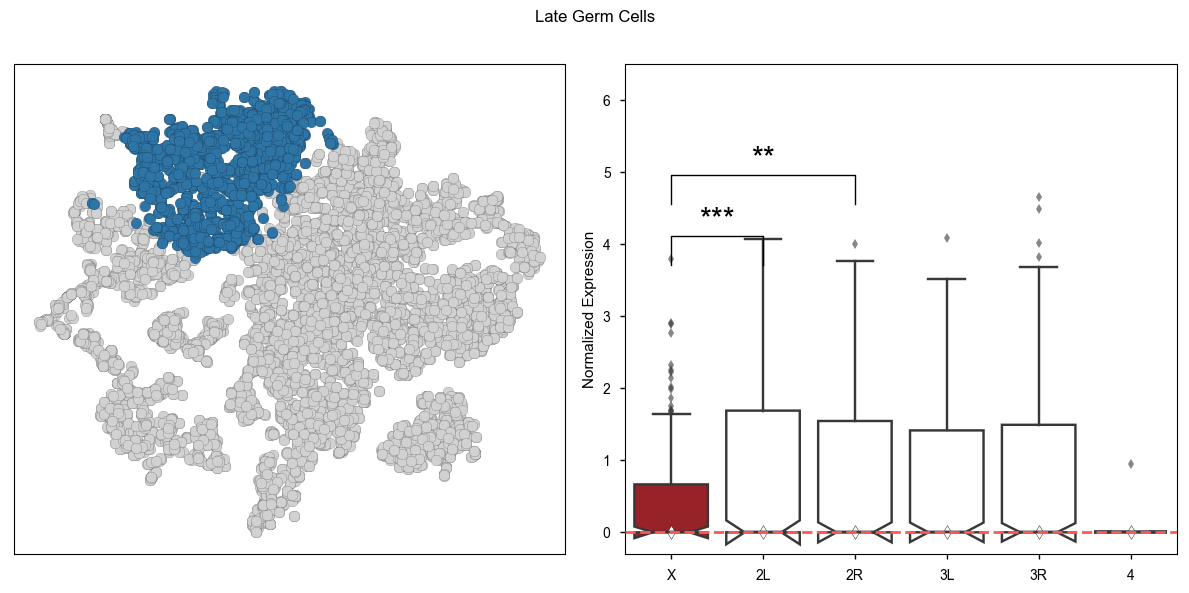

In [61]:
@make_figs(nbconfig.fig_name('tsne_boxplot_late2_germcells'), styles=nbconfig.styles, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .92]})
def _plot():
    plot_cluster_x2a(dat, expressed, 0, 'Late Germ Cells')
_plot()

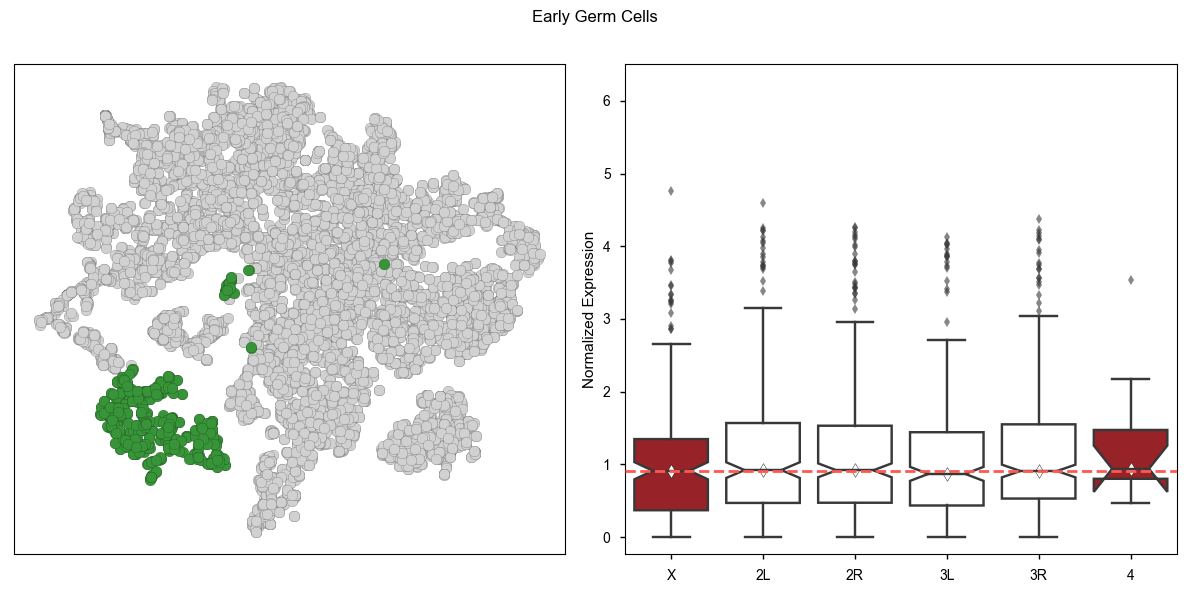

In [62]:
@make_figs(nbconfig.fig_name('tsne_boxplot_early_germcells'), styles=nbconfig.styles, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .92]})
def _plot():
    plot_cluster_x2a(dat, expressed, 4, 'Early Germ Cells')
_plot()

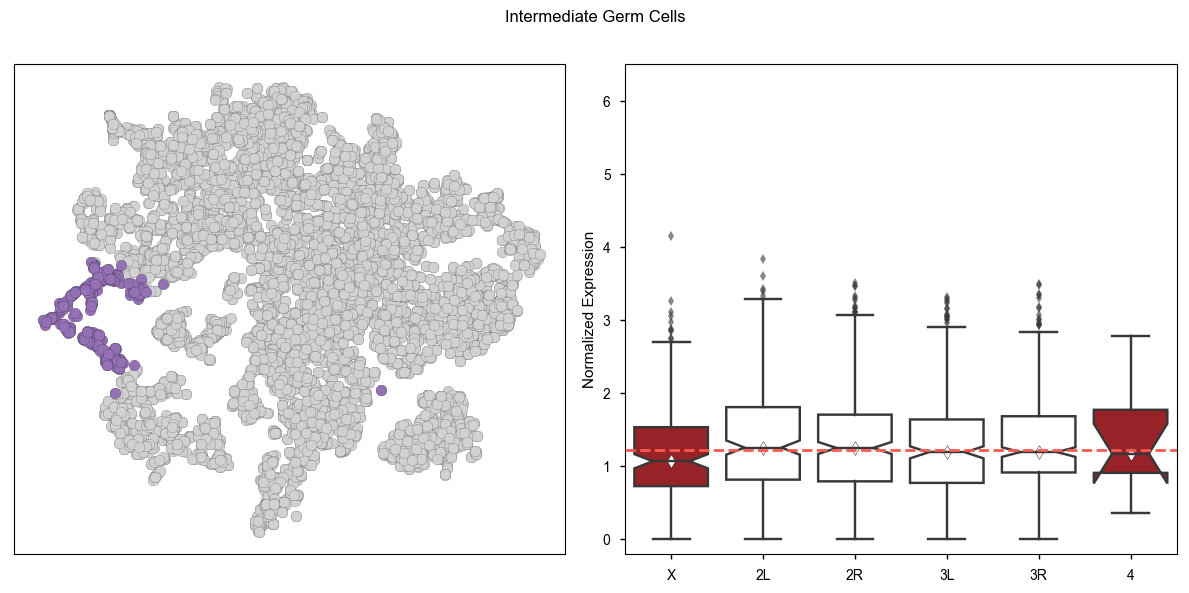

In [30]:
@make_figs(nbconfig.fig_name('tsne_boxplot_intermediate_germcells'), styles=nbconfig.styles, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .92]})
def _plot():
    plot_cluster_x2a(dat, expressed, 8, 'Intermediate Germ Cells')
_plot()

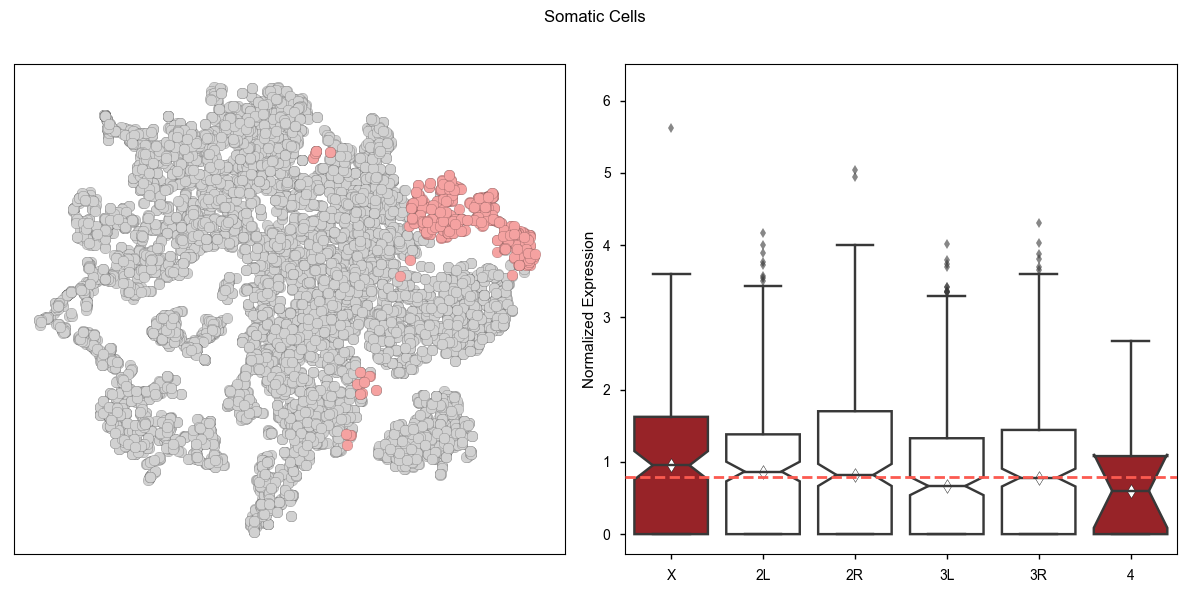

In [63]:
@make_figs(nbconfig.fig_name('tsne_boxplot_somatic_cells'), styles=nbconfig.styles, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .92]})
def _plot():
    plot_cluster_x2a(dat, expressed, 7, 'Somatic Cells')
_plot()

## X To A (ribosomal)

In [31]:
ribo = []
for k, v in nbconfig.symbol2fbgn.items():
    if k.startswith('RpL') | k.startswith('RpS'):
        ribo.append(v)

In [36]:
riboNorm = norm.loc[ribo, :]

In [42]:
riboMed = riboNorm.T.join(clusters['res.0.4']).groupby('res.0.4').median().T

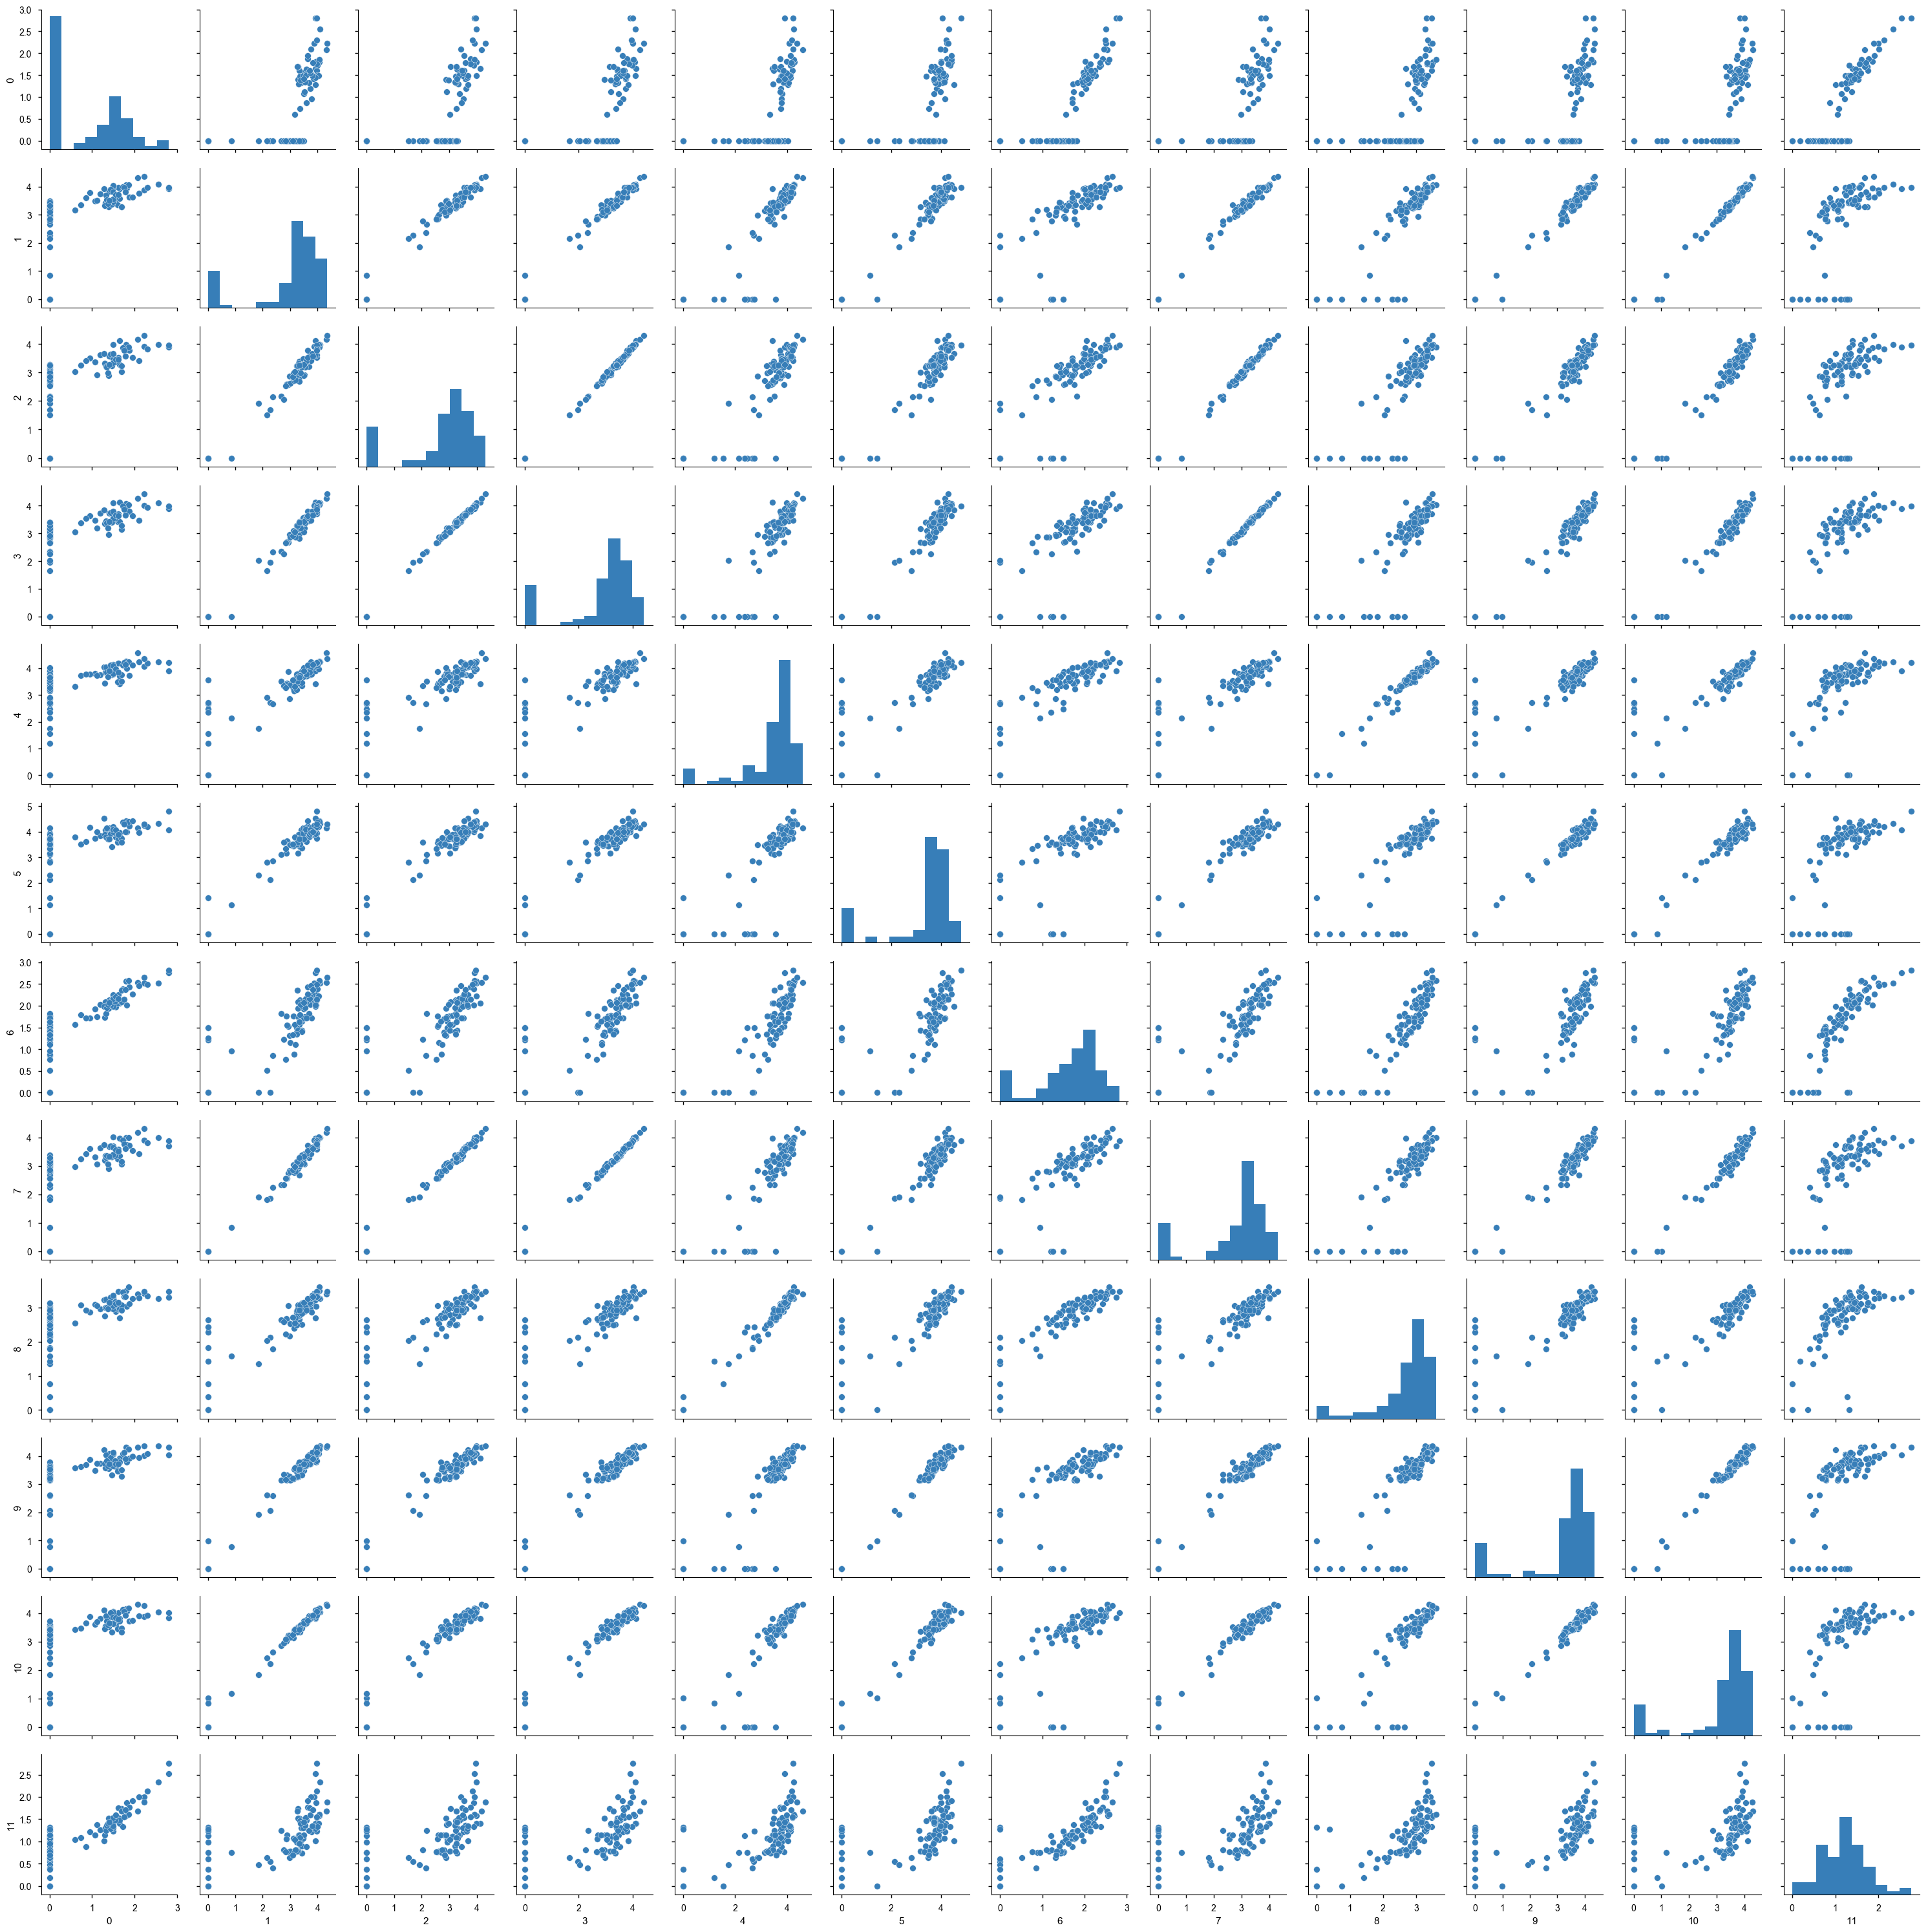

In [47]:
sns.pairplot(riboMed)

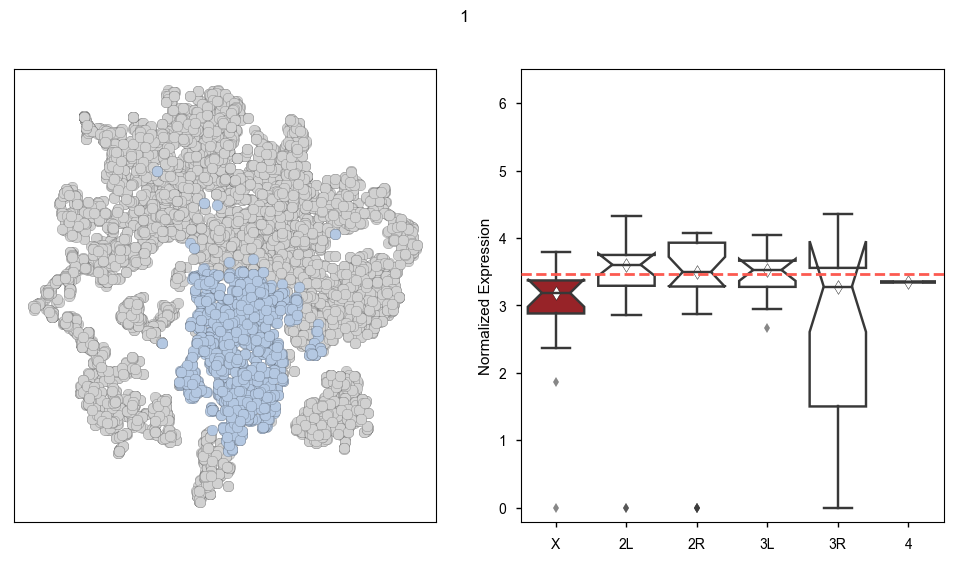

In [67]:
plot_cluster_x2a(dat, ribo, 1, '1')

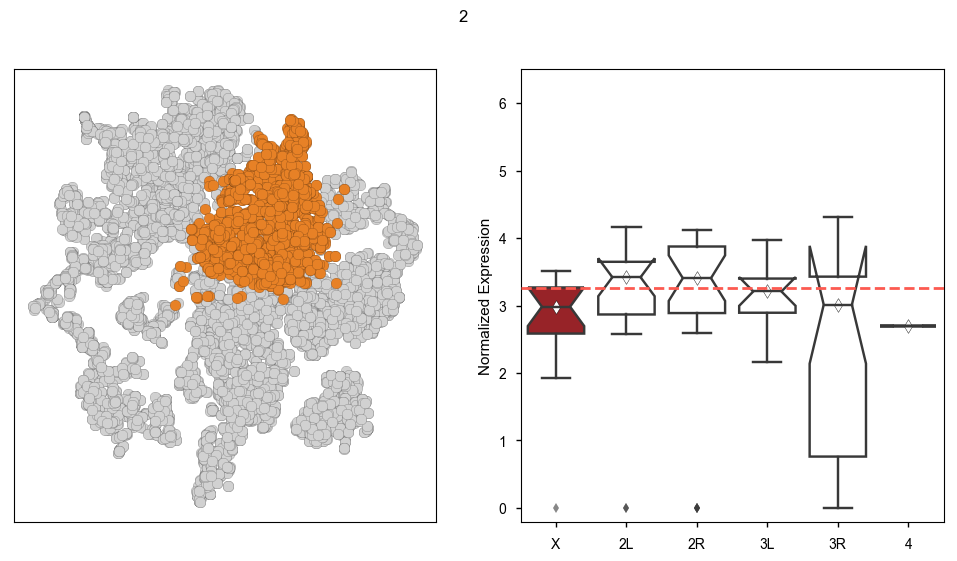

In [68]:
plot_cluster_x2a(dat, ribo, 2, '2')

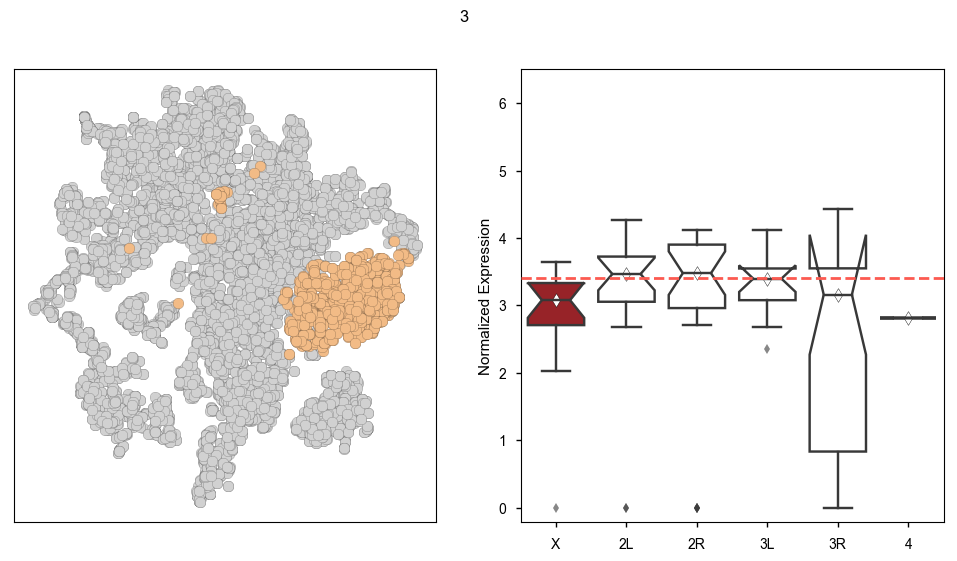

In [69]:
plot_cluster_x2a(dat, ribo, 3, '3')

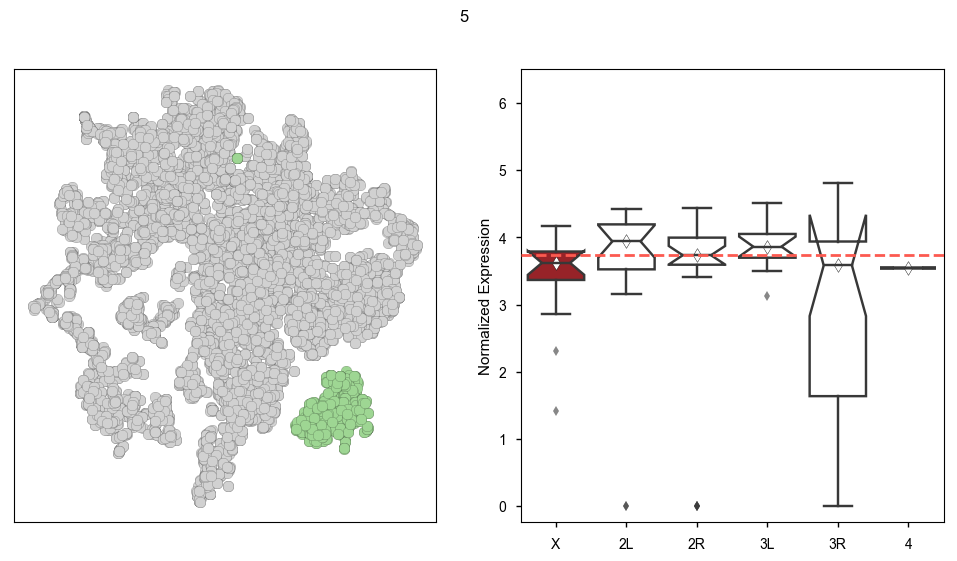

In [71]:
plot_cluster_x2a(dat, ribo, 5, '5')

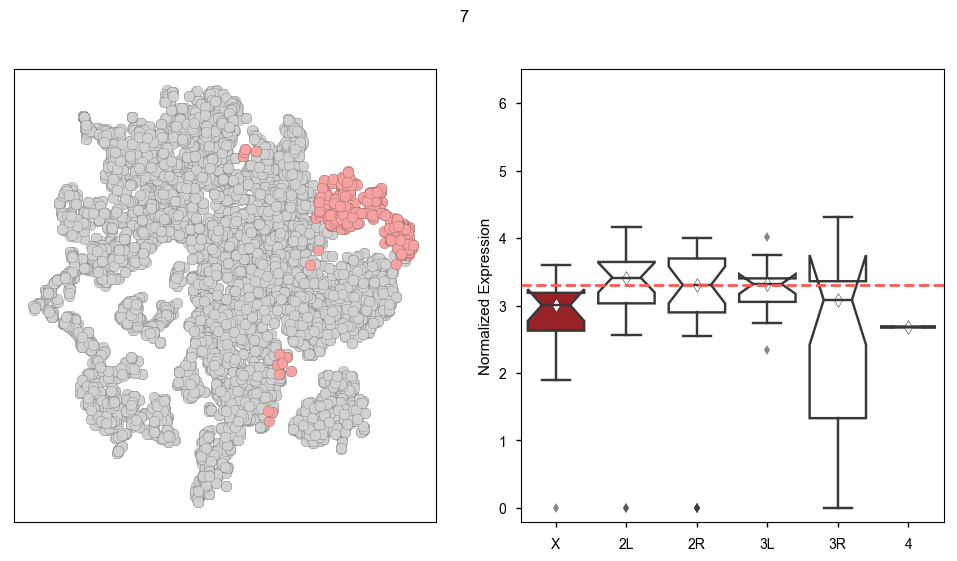

In [73]:
plot_cluster_x2a(dat, ribo, 7, '7')

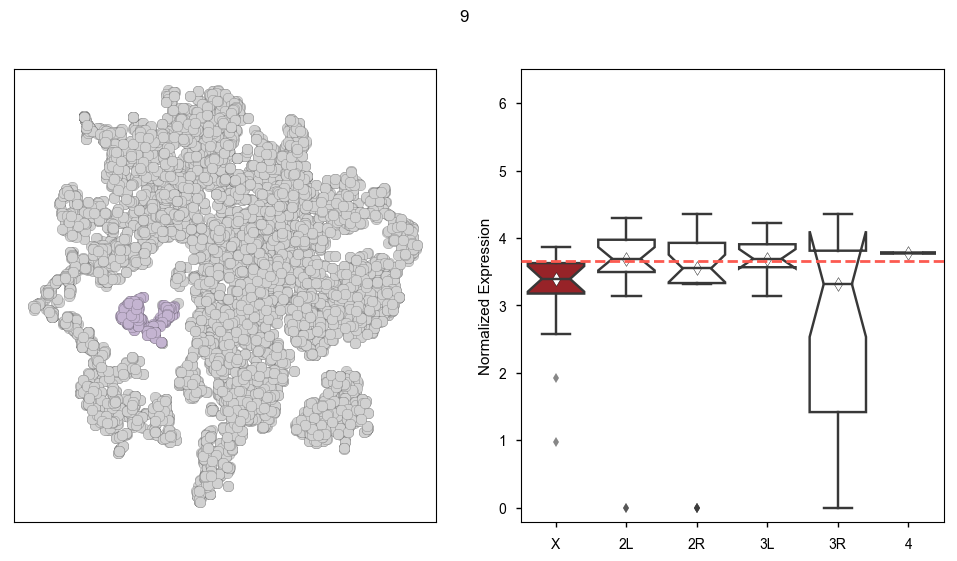

In [75]:
plot_cluster_x2a(dat, ribo, 9, '9')

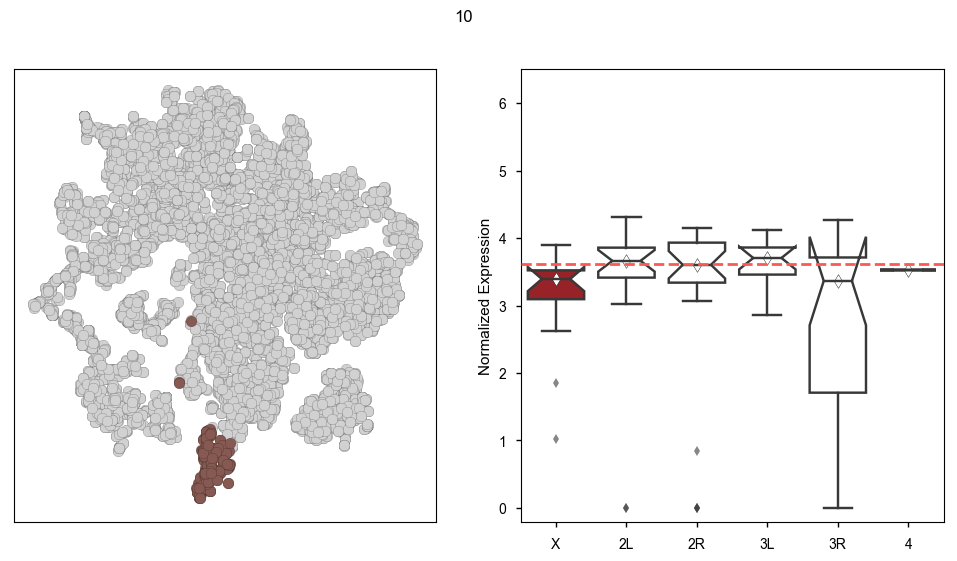

In [76]:
plot_cluster_x2a(dat, ribo, 10, '10')

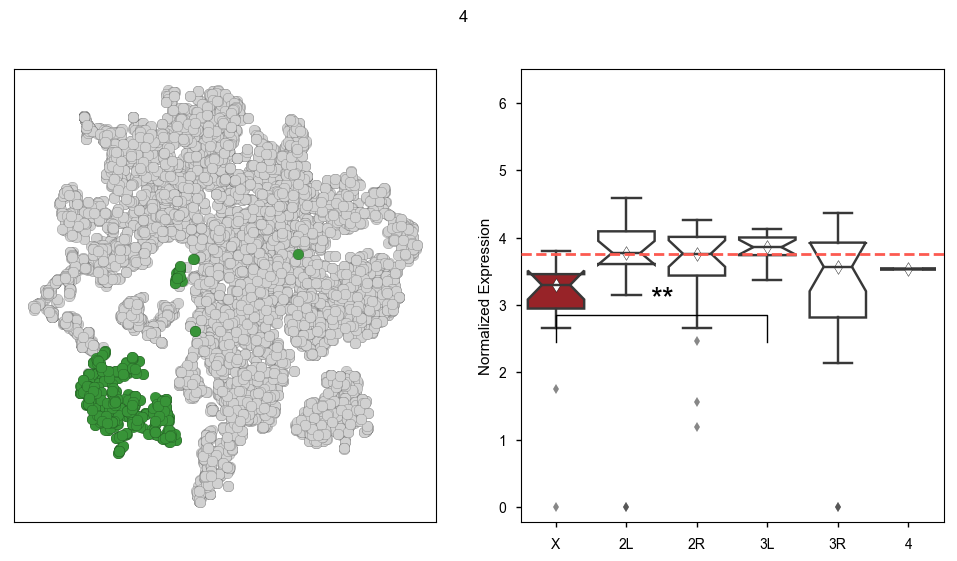

In [70]:
plot_cluster_x2a(dat, ribo, 4, '4')

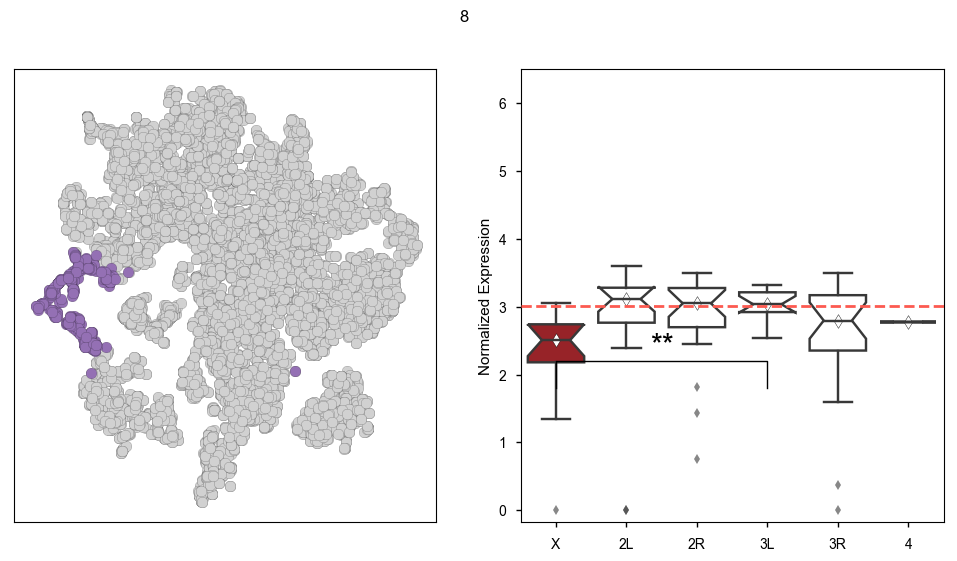

In [74]:
plot_cluster_x2a(dat, ribo, 8, '8')

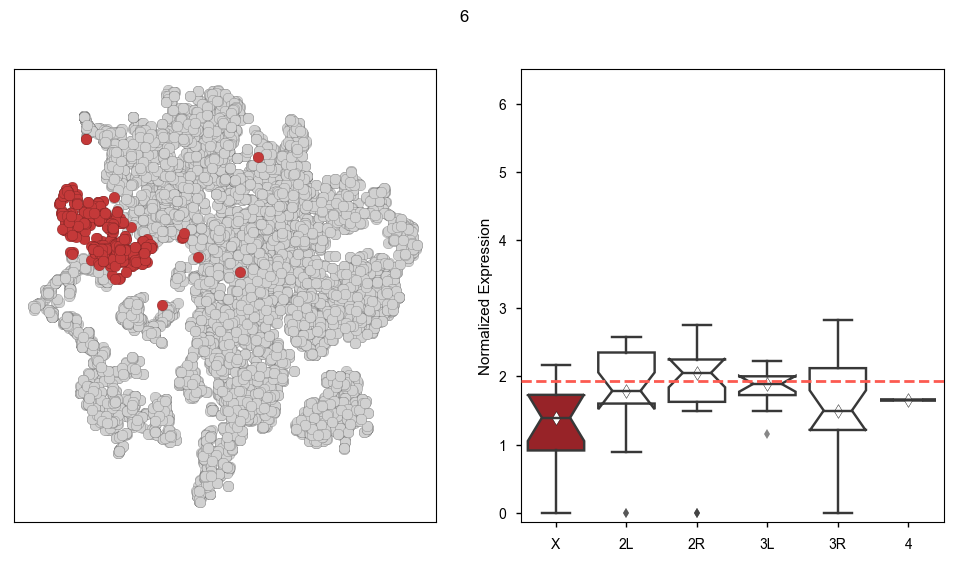

In [72]:
plot_cluster_x2a(dat, ribo, 6, '6')

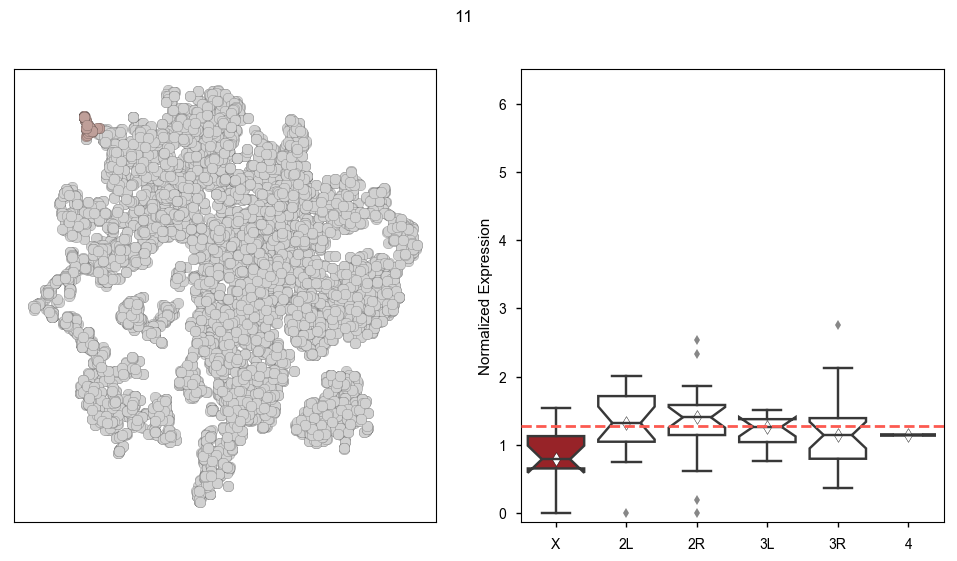

In [77]:
plot_cluster_x2a(dat, ribo, 11, '11')

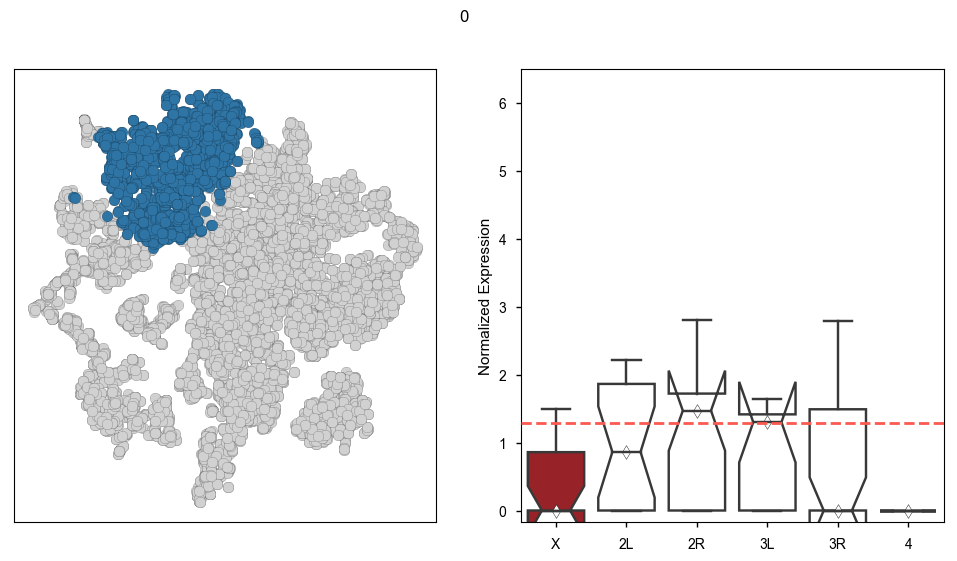

In [66]:
plot_cluster_x2a(dat, ribo, 0, '0')

In [86]:
nbconfig.fbgn2chrom.loc[ribo, 'chrom'].value_counts()

chr3R    23
chr2R    21
chr2L    19
chrX     14
chr3L    14
chr4      1
Name: chrom, dtype: int64

## Mitochondrial expression

In [90]:
mito = nbconfig.fbgn2chrom.query('chrom == "chrM"').index.tolist()

In [103]:
mitoNorm = norm[norm.index.isin(mito)].T.join(clusters['res.0.4']).groupby('res.0.4').median().T

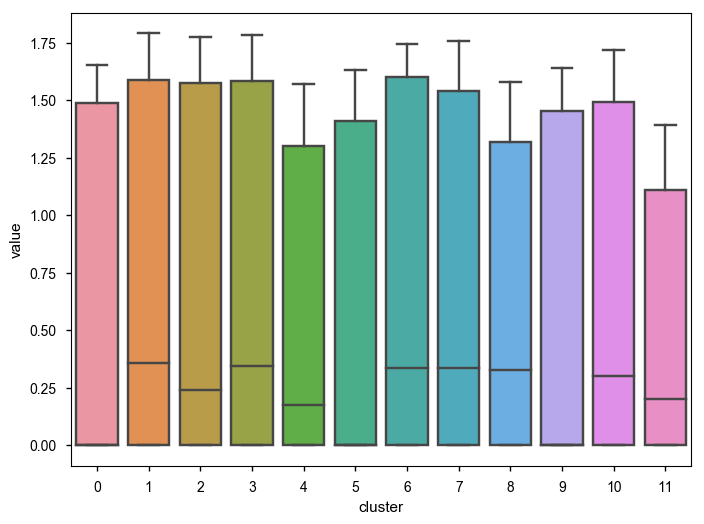

In [109]:
sns.boxplot(x='cluster', y='value', data=np.log1p(mitoNorm).melt(var_name='cluster'))

## Y linked gene expression

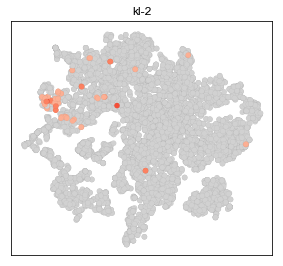

In [16]:
gene_tsne('kl-2')

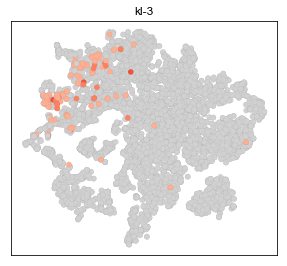

In [17]:
gene_tsne('kl-3')

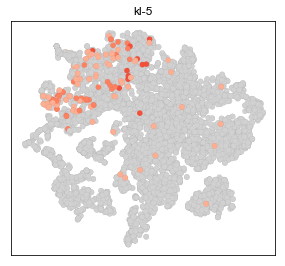

In [18]:
gene_tsne('kl-5')

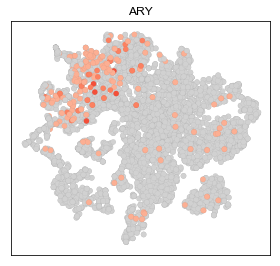

In [19]:
gene_tsne('ARY')

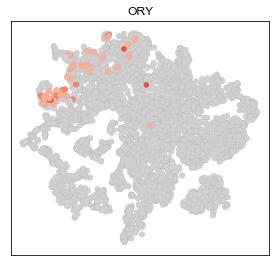

In [20]:
gene_tsne('ORY')

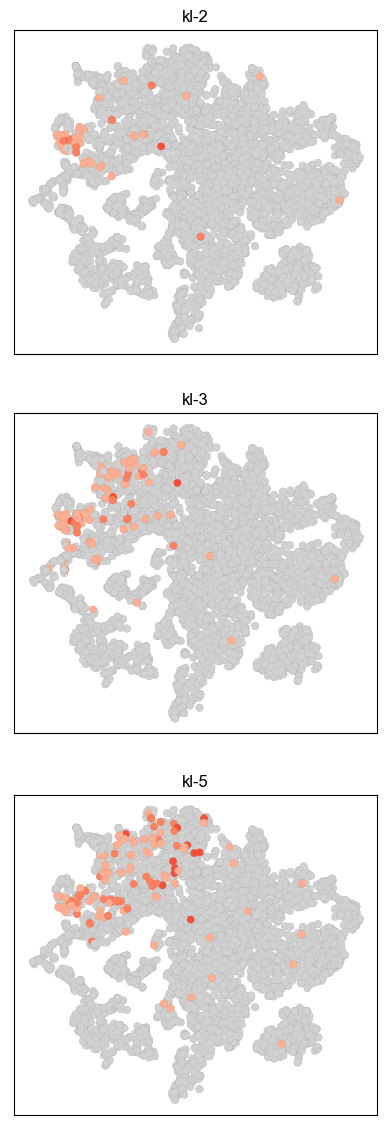

In [21]:
@make_figs(nbconfig.fig_name('tsne_kl_genes'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    genes = ['kl-2', 'kl-3', 'kl-5']
    fig, axes = plt.subplots(3, 1, figsize=plt.figaspect(3))
    for gene, ax in zip_longest(genes, axes):
        gene_tsne(gene, ax=ax)

plot_rep()

## Other interesting genes (MSL complex, dj/ocn)

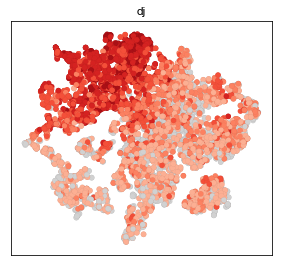

In [22]:
gene_tsne('dj')

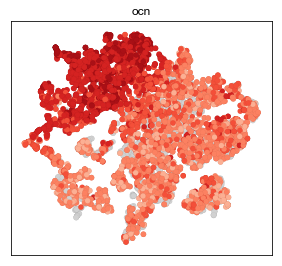

In [23]:
gene_tsne('ocn')

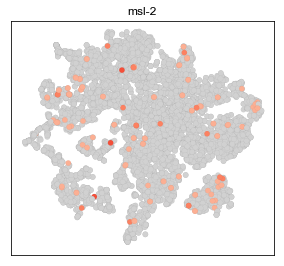

In [24]:
gene_tsne('msl-2')

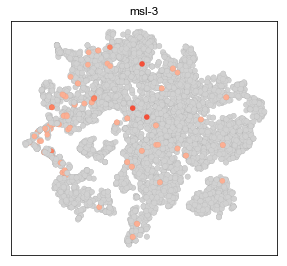

In [25]:
gene_tsne('msl-3')

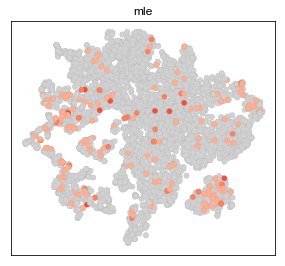

In [26]:
gene_tsne('mle')

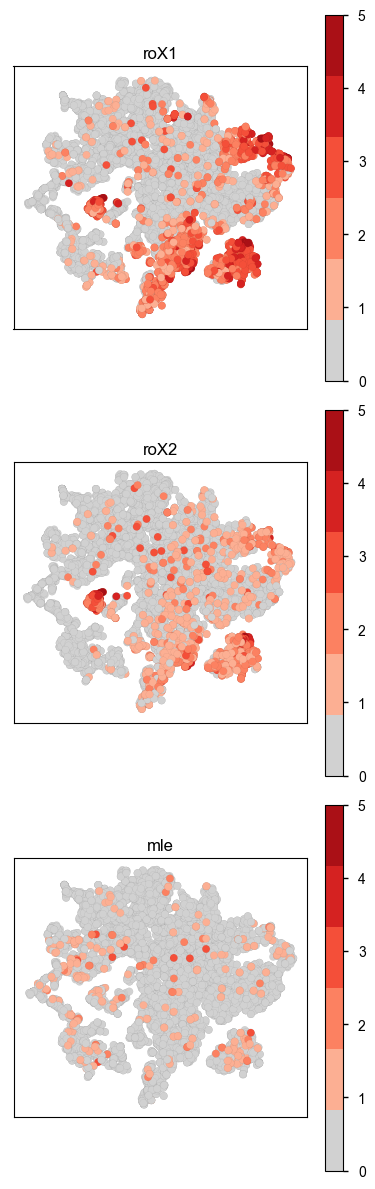

In [26]:
@make_figs(nbconfig.fig_name('tsne_dcc_genes'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    genes = ['roX1', 'roX2', 'mle']
    fig, axes = plt.subplots(3, 1, figsize=plt.figaspect(3))
    for gene, ax in zip_longest(genes, axes):
        gene_tsne(gene, ax=ax)

plot_rep()

## Cell Type markers

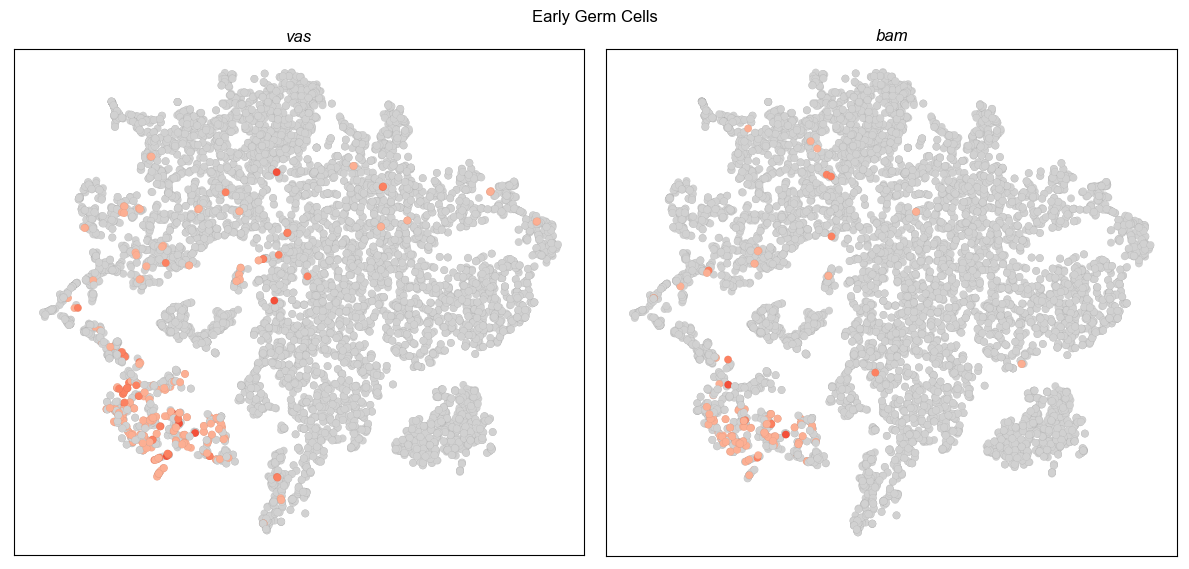

In [17]:
@make_figs(nbconfig.fig_name('tsne_early_germ'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
    gene_tsne('vas', ax=ax1)
    gene_tsne('bam', ax=ax2)
    plt.suptitle('Early Germ Cells');
plot_rep()

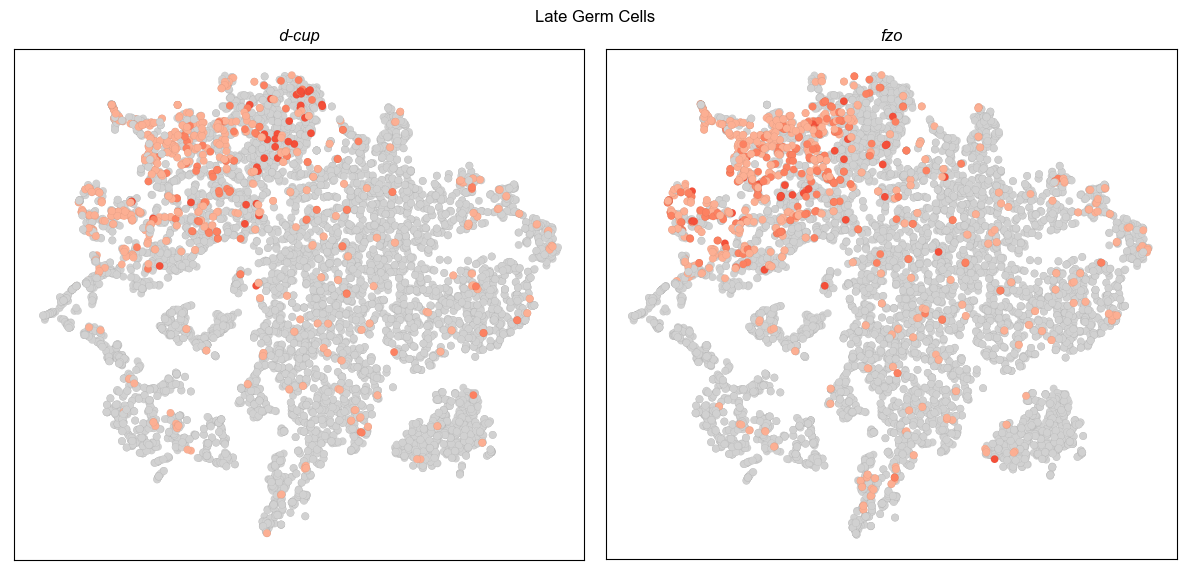

In [18]:
@make_figs(nbconfig.fig_name('tsne_late_germ'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
    gene_tsne('d-cup', ax=ax1)
    gene_tsne('fzo', ax=ax2)
    plt.suptitle('Late Germ Cells');
plot_rep()

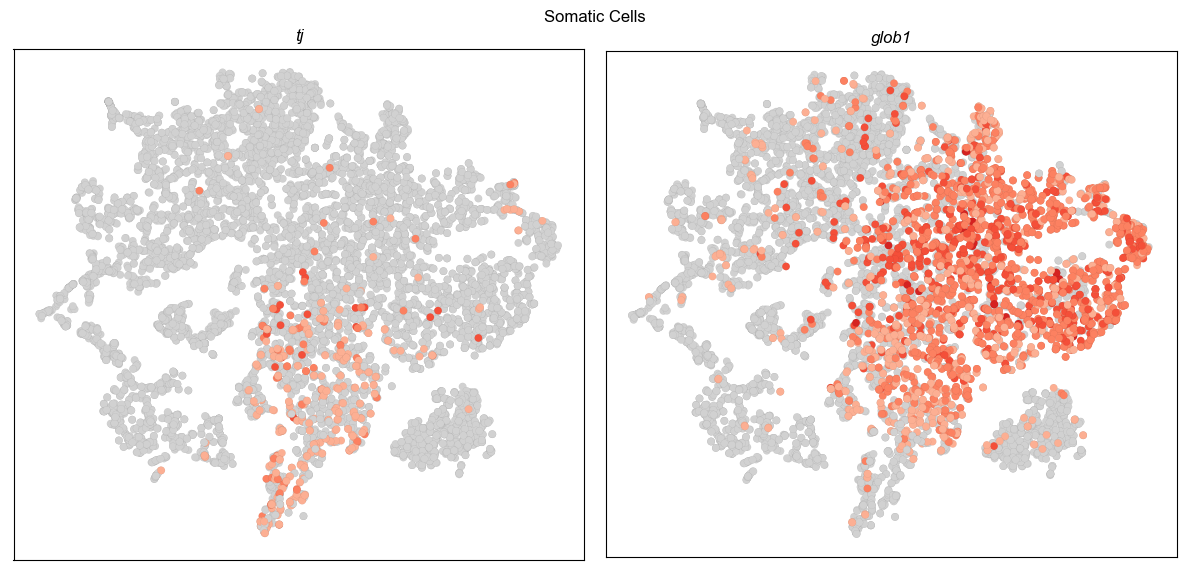

In [19]:
@make_figs(nbconfig.fig_name('tsne_soma'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
    gene_tsne('tj', ax=ax1)
    gene_tsne('glob1', ax=ax2)
    plt.suptitle('Somatic Cells');
plot_rep()

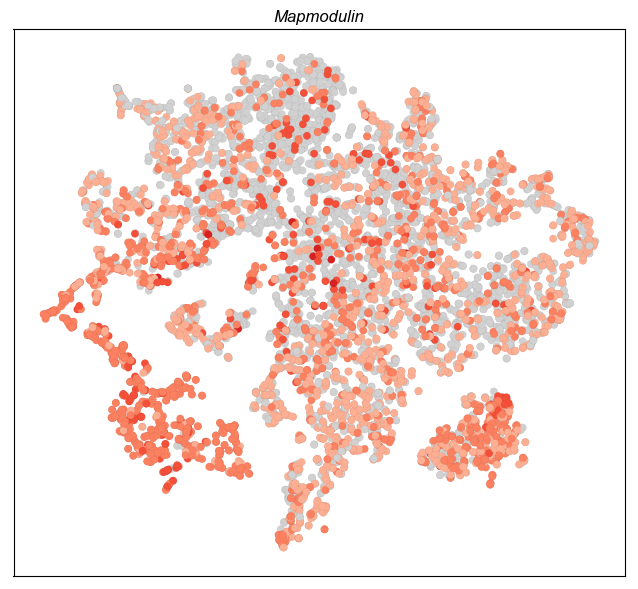

In [23]:
@make_figs(nbconfig.fig_name('tsne_Mapmodulin'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_rep():
    gene_tsne('Mapmodulin')
plot_rep()